# Credit

- ['University of Amsterdam' Deep Learning Course : Dynamical Systems & Neural ODEs (2022, Phillip Lippe)](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Dynamical_systems/dynamical_systems_neural_odes.html)

```python
@misc{lippe2022uvadlc,
   title        = {{UvA Deep Learning Tutorials}},
   author       = {Phillip Lippe},
   year         = 2022,
   howpublished = {\url{https://uvadlc-notebooks.readthedocs.io/en/latest/}}
}
```

# Import

In [1]:
%matplotlib inline
import time
from tqdm.auto import tqdm, trange
import logging
import statistics
from typing import Optional, List
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
from torch.utils.data import Dataset

try:
    import torchdiffeq
except ModuleNotFoundError:
    !pip install --quiet torchdiffeq
    import torchdiffeq

try:
    import rich
except ModuleNotFoundError:
    !pip install --quiet rich
    import rich

from utils_plot import *

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


# Prepare dataset

## Define dataset

In [2]:
class MoonsDataset(Dataset):
    """Half Moons Classification Dataset
    
    Adapted from https://github.com/DiffEqML/torchdyn
    """
    def __init__(self, num_samples=100, noise_std=1e-4):
        self.num_samples = num_samples
        self.noise_std = noise_std
        self.X, self.y = self.generate_moons(num_samples, noise_std)

    @staticmethod
    def generate_moons(num_samples=100, noise_std=1e-4):
        """Creates a *moons* dataset of `num_samples` data points.
        :param num_samples: number of data points in the generated dataset
        :type num_samples: int
        :param noise_std: standard deviation of noise magnitude added to each data point
        :type noise_std: float
        """
        num_samples_out = num_samples // 2
        num_samples_in = num_samples - num_samples_out
        theta_out = np.linspace(0, np.pi, num_samples_out)
        theta_in = np.linspace(0, np.pi, num_samples_in)
        outer_circ_x = np.cos(theta_out)
        outer_circ_y = np.sin(theta_out)
        inner_circ_x = 1 - np.cos(theta_in)
        inner_circ_y = 1 - np.sin(theta_in) - 0.5

        X = np.vstack([np.append(outer_circ_x, inner_circ_x),
                       np.append(outer_circ_y, inner_circ_y)]).T
        y = np.hstack([np.zeros(num_samples_out), np.ones(num_samples_in)])

        if noise_std is not None:
            X += noise_std * np.random.rand(num_samples, 2)

        X = torch.Tensor(X)
        y = torch.LongTensor(y)
        return X, y

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

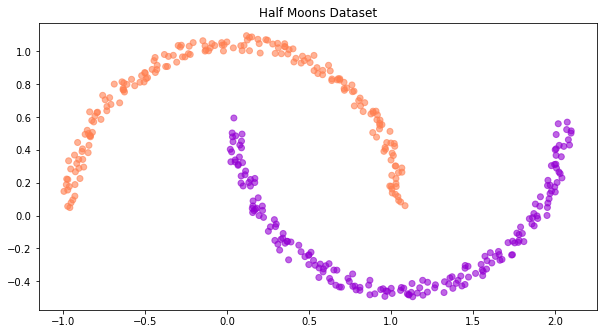

In [3]:
sample_dataset = MoonsDataset(num_samples=400, noise_std=1e-1)
fig, ax = plot_binary_classification_dataset(sample_dataset.X, sample_dataset.y, title='Half Moons Dataset')

## Define dataloader(mini batch size)

In [4]:
def split_dataset(dataset_size:int, split_percentages:List[float]) -> List[int]:
    split_sizes = [int(pi * dataset_size) for pi in split_percentages]
    split_sizes[0] += dataset_size - sum(split_sizes)
    return split_sizes

In [5]:
dataset_size=1_000
split_percentages = [0.8, 0.1, 0.1] # train / val / test
split_sizes = split_dataset(dataset_size, split_percentages)

# Dataset : Train, Valid, Test
dataset = MoonsDataset(num_samples=dataset_size, noise_std=1e-1)
train_set, val_set, test_set = torch.utils.data.random_split(dataset, split_sizes)

# Dataloader : Train, Valid, Test
train_loader = torch.utils.data.DataLoader(train_set, batch_size=len(train_set), shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=len(val_set), shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=False)

In [6]:
print(f'train batch shape : {next(iter(train_loader))[0].shape}')
print(f'val batch shape : {next(iter(val_loader))[0].shape}')
print(f'test batch shape : {next(iter(test_loader))[0].shape}')

train batch shape : torch.Size([800, 2])
val batch shape : torch.Size([100, 2])
test batch shape : torch.Size([100, 2])


# Define NeuralODE model

In [7]:
class _ODEFunc(nn.Module):
    def __init__(self, module, autonomous=True):
        super().__init__()
        self.module = module
        self.autonomous = autonomous

    def forward(self, t, x):
        if not self.autonomous:
            x = torch.cat([torch.ones_like(x[:, [0]]) * t, x], 1)
        return self.module(x)


class ODEBlock(nn.Module):
    def __init__(self, odefunc: nn.Module, solver: str = 'dopri5', # Dormand–Prince method
                 rtol: float = 1e-4, atol: float = 1e-4, adjoint: bool = True,
                 autonomous: bool = True):
        super().__init__()
        self.odefunc = _ODEFunc(odefunc, autonomous=autonomous)
        self.rtol = rtol  # optional float64 Tensor specifying an upper bound on relative error, per element of `y`.
        self.atol = atol  # optional float64 Tensor specifying an upper bound on absolute error, per element of `y`.
        self.solver = solver
        self.use_adjoint = adjoint
        self.integration_time = torch.tensor([0, 1], dtype=torch.float32) #[0, 1]
    
    @property
    def ode_method(self):
        # torchdiffeq.odeint_adjoint : https://github.com/rtqichen/torchdiffeq/blob/d794b12b7b986cd91cc2eeb3215d916ca376387c/torchdiffeq/_impl/adjoint.py#L156
        # torchdiffeq.odeint : https://github.com/rtqichen/torchdiffeq/blob/d794b12b7b986cd91cc2eeb3215d916ca376387c/torchdiffeq/_impl/odeint.py#L31
        return torchdiffeq.odeint_adjoint if self.use_adjoint else torchdiffeq.odeint

    def forward(self, x: torch.Tensor, adjoint: bool = True, integration_time=None):
        integration_time = self.integration_time if integration_time is None else integration_time
        integration_time = integration_time.to(x.device)
        ode_method = torchdiffeq.odeint_adjoint if adjoint else torchdiffeq.odeint
        out = ode_method(
            self.odefunc, x, integration_time, rtol=self.rtol,
            atol=self.atol, method=self.solver)
        return out

In [8]:
adjoint = True
t_span = torch.linspace(0, 1, 2)
max_epochs=300

# f : ODE function
f = nn.Sequential(
    nn.Linear(2, 64),
    nn.Tanh(),
    nn.Linear(64, 2)).to(device)

model = ODEBlock(f, adjoint=adjoint)
model = model.to(device)

In [9]:
model

ODEBlock(
  (odefunc): _ODEFunc(
    (module): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=2, bias=True)
    )
  )
)

In [10]:
f

Sequential(
  (0): Linear(in_features=2, out_features=64, bias=True)
  (1): Tanh()
  (2): Linear(in_features=64, out_features=2, bias=True)
)

In [11]:
learning_rate = float(5e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train loop

In [ ]:
train_logs = defaultdict(list)
val_logs = defaultdict(list)

pbar = trange(max_epochs, unit='epoch')

for epoch in pbar:
    
    # train loop
    model.train()
    for tr_batch in train_loader: 
        
        optimizer.zero_grad()
        
        x, y = tr_batch[0].to(device), tr_batch[1].to(device)
        y_pred = model(x)  # |y_pred| = (2, 800, 2), 0시점과 1시점의 각각의 value값(800, 2)(=: 2차원 상 800개 datapoints)
        y_pred = y_pred[-1]  # select last point(t=1) of solution trajectory

        loss = nn.CrossEntropyLoss()(y_pred, y)
        
        loss.backward()
        optimizer.step()
        
        # logging
        train_logs['train_loss'].append(torch.mean(loss).item())
        
    model.eval()
    with torch.no_grad():
        for vl_batch in val_loader:
            x_val, y_val = vl_batch[0].to(device), vl_batch[1].to(device)
            
            y_pred_val = model(x_val)
            y_pred_val = y_pred_val[-1]
            
            loss_val = nn.CrossEntropyLoss()(y_pred_val, y_val)
            val_logs['val_loss'].append(torch.mean(loss_val).item())
            
            acc_val = sum(torch.argmax(y_pred_val.softmax(dim=-1), dim=-1).__eq__(y_val)) / len(y_val)
            val_logs['val_acc'].append(acc_val.item())            
        
    pbar.set_postfix(train_loss=train_logs['train_loss'][-1])
pbar.close()

  0%|          | 0/300 [00:00<?, ?epoch/s]

# Inference

In [ ]:
time_span = np.linspace(0.0, 1.0, 100)
time_span = torch.from_numpy(time_span).to(device)

with torch.no_grad():
    trajectories = []
    classes = []
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        # |traj| = (100, 800, 2), 100개의 0.0과 1.0사이 evaluation time step에서의 sample points(800,2)의 values
        traj = model(x, adjoint=False, integration_time=time_span).cpu().numpy()
        trajectories.append(traj)
        classes.extend(y.cpu().numpy())
    trajectories = np.concatenate(trajectories, 1) # |trajectories| = (100, 800, 2)

# Visualization

## Trajectories in continuous steps

In [ ]:
colors = ['coral', 'darkviolet']
class_colors = [colors[ci] for ci in classes]

In [ ]:
fig, ax = plot_binary_classification_dataset(*train_set[:], title='Half Moons Dataset')

In [ ]:
plot_trajectories(time_span.cpu().numpy(), trajectories, class_colors, save='assets/NODE_trajectories')

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(30, 5))
idx_shows = [0, 15, 30, 50, 70, 85, 99]
color=[['coral', 'darkviolet'][yi.int()] for yi in y]

for idx, n_shows in enumerate(idx_shows):
    ax[idx].scatter(trajectories[n_shows][:].T[0][:], 
                    trajectories[n_shows][:].T[1][:],
                    color=color, alpha=0.6)

In [ ]:
make_gif(trajectories, y, save_path='assets/halfmoon', duration=.2, dpi=300)

In [ ]:
plot_trajectories_3d(time_span.cpu().numpy(), trajectories, class_colors, save='assets/NODE_trajectories_3d')

## State-Space Diagram

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

for i in range(trajectories.shape[1]):  # i = [1,800]
    # |trajectories| = (100, 800, 2)
    ax.plot(trajectories[:, i, 0], trajectories[:, i, 1],
            color=class_colors[i], alpha=0.1)

ax.set_title('State-Space Diagram')
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
plt.savefig("assets/NODE_state_space.png")
plt.show()

## vector field

Make meshgrid

In [ ]:
N=50
# |trajectories| = (100, 800, 2(=X,Y))
X, Y = np.mgrid[trajectories[:, 0].min():trajectories[:, 0].max():N*1j,
                trajectories[:, 1].min():trajectories[:, 1].max():N*1j]
X = X.T # |X| = (50=N, 50=N)
Y = Y.T # |Y| = (50=N, 50=N)

P = np.vstack([X.ravel(), Y.ravel()]).T  # |X.ravel()|=(2500,), |P|=(2500,2)
P = torch.Tensor(P).to(device)

Predict slope and make 'vector field'

In [ ]:
with torch.no_grad():
    # The output of "model.odefunc(0.0, P)" : Vector field
    # model.odefunc(학습 대상인 slope function)은 이미 앞서 우리가 학습한 상태
    # 따라서 학습이 완료된 slope function을 따라 각 location(X, Y meshgrid)에서의 slope를 plot("streamplot")
    vector_field = model.odefunc(0.0, P).cpu()  # odefunc(t, x), #|vector_field| = (2500, 2)
    
vector_norm = vector_field.norm(dim=1).view(N, N).numpy()  # |vector_norm| = (50, 50) <= for normalize vector field
vector_field = vector_field.view(N, N, 2).numpy()  # |vector_field| = (50, 50, 2)

Plot 'vector field'

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.contourf(X, Y, vector_norm, cmap='RdYlBu',)  #|X|, |Y| = (50,50), |vector_norm|=(50,50)
ax.streamplot(X, Y, vector_field[:, :, 0], vector_field[:, :, 1], color='k')

ax.set_xlim([X.min(), X.max()])
ax.set_ylim([Y.min(), Y.max()])
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_title("Learned Vector Field")
plt.savefig("assets/NODE_vector_field.png")
plt.show()

# Augmented Neural ODEs

## Define 'Augmentor'

In [ ]:
class ZeroAugmenter(nn.Module):
    def __init__(self, axis=1, num_dims=1):
        super().__init__()
        self.axis = axis
        self.num_dims = num_dims

    def forward(self, x):
        aug_dims = list(x.shape)
        aug_dims[self.axis] = self.num_dims
        augmentation = torch.zeros(aug_dims, device=x.device, dtype=x.dtype)
        return torch.cat([x, augmentation], dim=self.axis)


class AugmentedNODEWrapper(nn.Module):
    def __init__(self, augmenter, neural_ode, out_net):
        super().__init__()
        self.augmenter = augmenter
        self.neural_ode = neural_ode
        self.out_net = out_net

    def forward(self, x: torch.Tensor, adjoint: bool = True, integration_time=None):
        x = self.augmenter(x)
        x = self.neural_ode(x, adjoint, integration_time)
        x = self.out_net(x)
        return x

    def forward_no_projection(self, x: torch.Tensor, adjoint: bool = True, integration_time=None):
        x = self.augmenter(x)
        x = self.neural_ode(x, adjoint, integration_time)
        return x

### Augmentation in ```ZeroAugmenter```

In [ ]:
za = ZeroAugmenter(num_dims=1)
za

In [ ]:
x

In [ ]:
za(x)

## Define Model

In [ ]:
adjoint = True
t_span = torch.linspace(0, 1, 2)

augmentation_dims = 1
f = nn.Sequential(nn.Linear(2+augmentation_dims, 64), nn.Tanh(), nn.Linear(64, 2+augmentation_dims)).to(device)
no_augm_model = ODEBlock(f, adjoint=adjoint).to(device)

# augmentor (2 -> 3, augmentation) 
### ex) [[ 0.4876,  0.9529], ..] -> [[ 0.4876,  0.9529, 0.0], ..]
# neural_ode(=slope function '3 -> 64 -> 3')
# out_net(projector, 3 -> 2, projection)
model = AugmentedNODEWrapper(ZeroAugmenter(num_dims=augmentation_dims), 
                             no_augm_model,                             
                             nn.Linear(2+augmentation_dims, 2)).to(device)

In [ ]:
f

In [ ]:
no_augm_model

In [ ]:
model

## Train loop

In [ ]:
learning_rate = float(5e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_logs = defaultdict(list)
val_logs = defaultdict(list)

pbar = trange(max_epochs, unit='epoch')

for epoch in pbar:
    
    # train loop
    model.train()
    for tr_batch in train_loader: 
        
        optimizer.zero_grad()
        
        x, y = tr_batch[0].to(device), tr_batch[1].to(device)
        y_pred = model(x)  # |y_pred| = (2, 800, 2), 0시점과 1시점의 각각의 value값(800, 2)(=: 2차원 상 800개 datapoints)
        y_pred = y_pred[-1]  # select last point(t=1) of solution trajectory

        loss = nn.CrossEntropyLoss()(y_pred, y)
        
        loss.backward()
        optimizer.step()
        
        # logging
        train_logs['train_loss'].append(torch.mean(loss).item())
        
    model.eval()
    with torch.no_grad():
        for vl_batch in val_loader:
            x_val, y_val = vl_batch[0].to(device), vl_batch[1].to(device)
            
            y_pred_val = model(x_val)
            y_pred_val = y_pred_val[-1]
            
            loss_val = nn.CrossEntropyLoss()(y_pred_val, y_val)
            val_logs['val_loss'].append(torch.mean(loss_val).item())
            
            acc_val = sum(torch.argmax(y_pred_val.softmax(dim=-1), dim=-1).__eq__(y_val)) / len(y_val)
            val_logs['val_acc'].append(acc_val.item())            
        
    pbar.set_postfix(train_loss=train_logs['train_loss'][-1])
pbar.close()

## Inference

In [ ]:
time_span = np.linspace(0.0, 1.0, 100)
time_span = torch.from_numpy(time_span).to(device)

with torch.no_grad():
    trajectories = []
    classes = []
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        # |traj| = (100, 800, 2), 100개의 0.0과 1.0사이 evaluation time step에서의 sample points(800,2)의 values
        traj = model(x, adjoint=False, integration_time=time_span).cpu().numpy()
        trajectories.append(traj)
        classes.extend(y.cpu().numpy())
    trajectories = np.concatenate(trajectories, 1) # |trajectories| = (100, 800, 2)

## Visualization

In [ ]:
colors = ['coral', 'darkviolet']
class_colors = [colors[ci] for ci in classes]

In [ ]:
plot_state_space(trajectories, class_colors)

In [ ]:
make_gif(trajectories, y, save_path='assets/halfmoon_augNODE', duration=.2, dpi=300)

In [ ]:
plot_trajectories_3d(time_span.cpu().numpy(), trajectories, class_colors)